In [2]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])


# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D) # works unless on endpoint


def generate_segment(start, end, n):
    return np.array([start + (end - start) * t for t in np.linspace(0, 1, n)])


def compute_voronoi(points: np.ndarray, data):

    vor = Voronoi(points)  # calculate the voronoi diagram using Scipy 

    fig = voronoi_plot_2d(vor, show_points=False, show_vertices=False)  # create initial figure
    
    # get figure limits for later plotting
    xl, xu = fig.axes[0].get_xlim()
    yl, yu = fig.axes[0].get_ylim()
    plt.show()  # need to do to create new fig

    # get segments from plot
    ax = fig.axes[0]
    segments = ax.collections[0].get_segments()

    # create a reshaped version for indexing
    # for each segment, check if it intersects any of the 
    for seg in segments:
        ((x0, y0), (x1, y1)) = seg

        intersect_list = [intersect((x0, y0), (x1, y1), i[0], i[1]) for i in data]
        # if intersect((x0, y0), (x1, y1), p1, p2) == False and intersect((x0, y0), (x1, y1), p3, p4) == False and intersect((x0, y0), (x1, y1), p5, p6) == False and intersect((x0, y0), (x1, y1), p7, p8) == False:
        if not any(intersect_list):
            plt.plot([x0, x1], [y0, y1], color="k", linewidth=1)


    # plot the remaining voronoi edges
    segments = ax.collections[1].get_segments()
    for seg in segments:
        ((x0, y0), (x1, y1)) = seg
        plt.plot([x0, x1], [y0, y1], color="k", linewidth=1)

    
    for i in data:
        plt.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], color="tab:blue")

    plt.title('Approximated Voronoi Diagram for a Line Segment')
    plt.xlim(xl, xu)
    plt.ylim(yl, yu)
    plt.show()

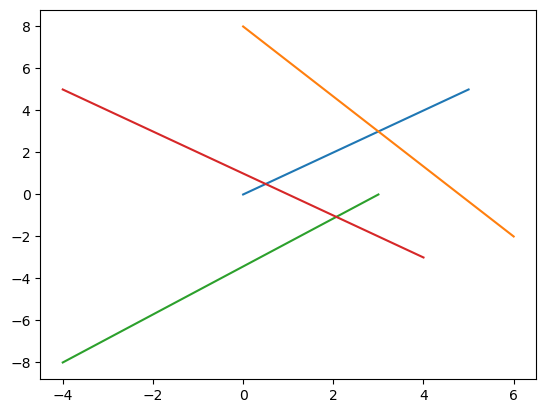

In [3]:
data = pd.read_csv("test.csv")
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100
data = data.to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)


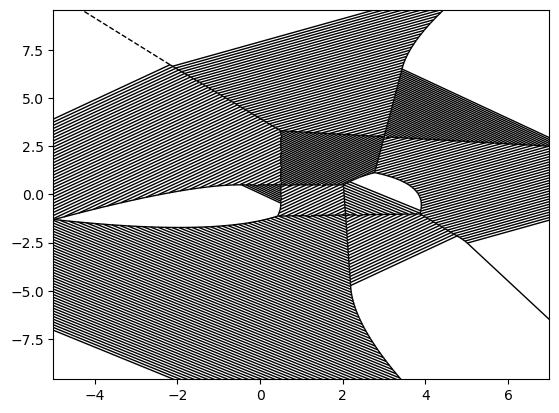

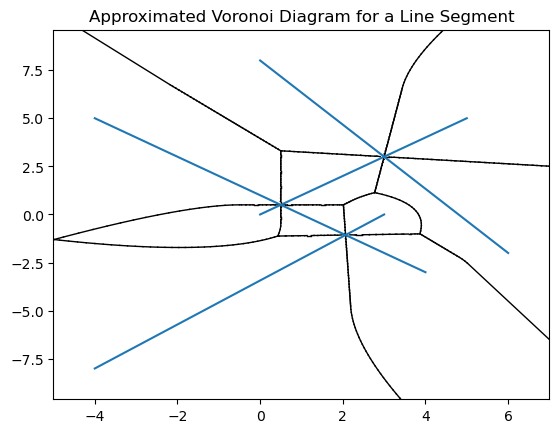

In [4]:
compute_voronoi(segs, data)

In [ ]:
data = pd.read_csv("highwaysegments_fullstate.csv")
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100
data = data.to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)
compute_voronoi(segs, data)

(406, 2)


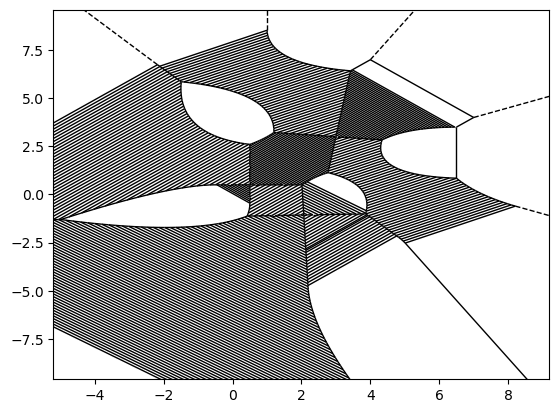

203


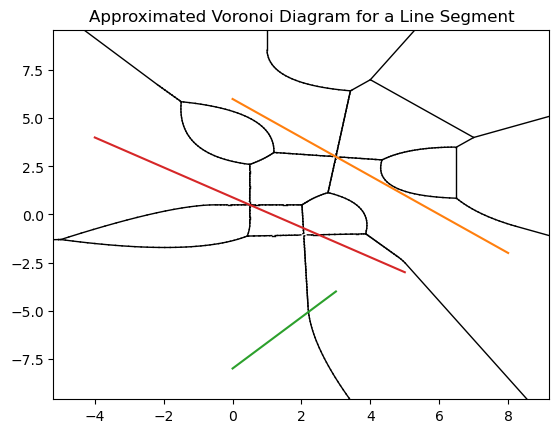

In [301]:

# Define the start and end points of the line segment
p1 = np.array([0, 0])  # start
p2 = np.array([5, 5])  # end
p3 = np.array([0, 8])
p4 = np.array([6, -2])

p5 = np.array([3, 0])
p6 = np.array([-4, -8])

p7 = np.array([-4, 5])
p8 = np.array([4, -3])



# Generate points along the line segment
num_points = 100  # Adjust for desired accuracy

seg1 = generate_segment(p1, p2, num_points)
seg2 = generate_segment(p3, p4, num_points)
seg3 = generate_segment(p5, p6, num_points)
seg4 = generate_segment(p7, p8, num_points)



# Add some other "seed" points to see the effect of the segment
other_points = np.array([[2, 8], [8, 2], [3, -2], [0, 4], [6, 6], [5, 2]])  # regular points



all_points = np.vstack((seg1, seg2, seg3, seg4, other_points))
print(all_points.shape)

compute_voronoi(all_points, data)

TypeError: compute_voronoi() missing 1 required positional argument: 'data'

[1]
xi:-6, xf:-10, yi:-6, yf:-10
xi:6, xf:10, yi:6, yf:10


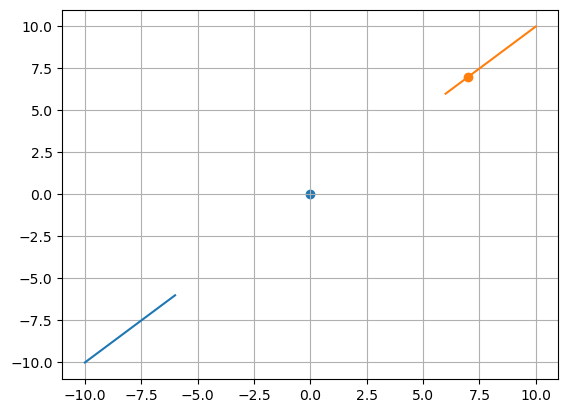

In [16]:
# pyvoronoi version of voronoi diagram of line segment
import pyvoronoi
pv = pyvoronoi.Pyvoronoi(1)

segs = [
    # xi, yi    xf, yf
    [[-6, -6], [-10, -10]], 
    [[6, 6], [10, 10]]
        ]

pts = [
    [0, 0],
    [7, 7]
    ]



# Those two segments do not intersect or overlap anything
pv.AddSegment(segs[0])
pv.AddSegment(segs[1])

# The second point is located on the second segment
pv.AddPoint(pts[0])
pv.AddPoint(pts[1])

pv.Construct()
# Will return [1] as the second point is on the second segment
invalid_points = pv.GetPointsOnSegments()
print(invalid_points)


for seg in segs:
    print(f"xi:{seg[0][0]}, xf:{seg[1][0]}, yi:{seg[0][1]}, yf:{seg[1][1]}")
    plt.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]])


for pt in pts:
    plt.scatter(pt[0], pt[1])

plt.grid()

# [seg["U0"].iloc[j], seg["V0"].iloc[j]], [seg["U1"].iloc[j], seg["V1"].iloc[j]]

[0.3, 0.75, 0.25] [0.25, 0.5, 1]
vertex 0 is located at (0.5, 0.5)
edge 0 starts at 0 and ends at -1 
edge 1 starts at -1 and ends at 0 
edge 2 starts at -1 and ends at 0 
edge 3 starts at 0 and ends at -1 
edge 4 starts at -1 and ends at 0 
edge 5 starts at 0 and ends at -1 
0 [2, 0] [-1, 0, -1] 0
1 [5, 1] [0, -1, 0] 2
2 [4, 3] [-1, 0, -1] 1


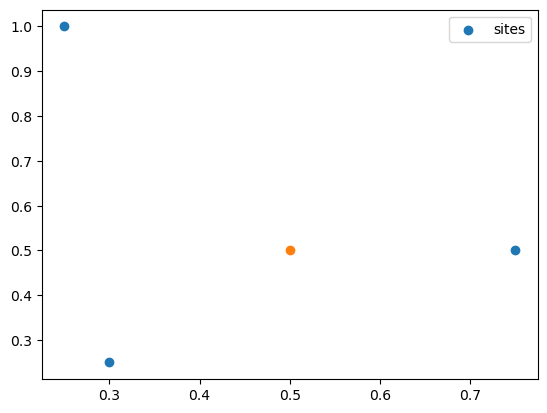

In [ ]:
import pyvoronoi
import matplotlib.pyplot as plt

# -----------------------------
# 1. Build Voronoi diagram
# -----------------------------
pv = pyvoronoi.Pyvoronoi()

points = [
    [0.30, 0.25],
    [0.75, 0.5],
    [0.25, 1]
]

x = [p[0] for p in points]
y = [p[1] for p in points]
for p in points:
    pv.AddPoint(p)

pv.Construct()

# -----------------------------
# 2. Plot
# -----------------------------
plt.subplot(111)
print(x, y)
plt.scatter(x, y, label="sites")

# Plot voronoi vertex
for index, vertex in pv.EnumerateVertices():
    print(f"vertex {index} is located at {vertex.X, vertex.Y}")
    plt.scatter(vertex.X, vertex.Y)

for index, edge in pv.EnumerateEdges():
    print(f"edge {index} starts at {edge.start} and ends at {edge.end}")


for index, cell in pv.EnumerateCells():
    print(index, cell.edges, cell.vertices, cell.site)
plt.legend()
plt.show()